In [1]:
import sys
sys.path.insert(0, '/tf/pollock')

In [2]:
import logging
import os
import random
from collections import Counter
from importlib import reload


import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

## gpu stuff

In [ ]:
# from importlib import reload
# reload(pollock)
# reload(pollock.models.model)

In [ ]:
# from tensorflow.python.client import device_lib
# import tensorflow as tf
# device_lib.list_local_devices()

In [ ]:
# tf.config.list_physical_devices('XLA_GPU')

In [ ]:
# tf.keras.backend.clear_session()
# tf.config.optimizer.set_jit(True)

In [ ]:
# mirrored_strategy = tf.distribute.MirroredStrategy(
#     devices=["/device:XLA_GPU:0"])

In [ ]:
# pollock.models.model.set_training_devices(['/device:XLA_GPU:0'])

## load in expression table and labels

In [5]:
DATA_DIR = '/home/estorrs/data/single_cell_classification'
MODEL_DIR = '/home/estorrs/pollock/models'

In [8]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

#### set filepaths and parameters

###### scRNAseq benchmark

In [6]:
run_name = 'allen_mouse_brain_class'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Filtered_mouse_allen_brain_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'Class'

n_per_cell_type = 2000
epochs = 5
batch_size = 64

In [34]:
run_name = 'allen_mouse_brain_subclass'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Filtered_mouse_allen_brain_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'Subclass'

n_per_cell_type = 2000
epochs = 5
batch_size = 64

In [73]:
run_name = 'allen_mouse_brain_cluster'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Filtered_mouse_allen_brain_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'cluster'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [203]:
run_name = 'cell_bench_10x_5cl'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', '10x_5cl', '10x_5cl_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', '10x_5cl', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'cell_bench_10x_CelSeq2_5cl'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', 'CelSeq2_5cl', '10x_CelSeq2_5cl_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', 'CelSeq2_5cl', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [6]:
run_name = 'pancreatic_baron_human_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Human', 'Filtered_Baron_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Human', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 2000
epochs = 5
batch_size = 64

In [230]:
run_name = 'pancreatic_baron_mouse_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Mouse', 'Filtered_MousePancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Mouse', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [243]:
run_name = 'pancreatic_muraro_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Muraro', 'Filtered_Muraro_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Muraro', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [257]:
run_name = 'pancreatic_segerstolpe_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Segerstolpe', 'Filtered_Segerstolpe_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Segerstolpe', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [271]:
run_name = 'pancreatic_xin_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Xin', 'Filtered_Xin_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Xin', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [6]:
run_name = 'tm_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'TM', 'Filtered_TM_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'TM', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [9]:
run_name = 'zheng_68k_unsorted'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Filtered_68K_PBMC_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 10000
epochs = 5
batch_size = 64

In [25]:
run_name = 'zheng_sorted'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng sorted', 'Filtered_DownSampled_SortedPBMC_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng sorted', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_10x-v2'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv2', '10Xv2_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv2', '10Xv2_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [42]:
run_name = 'pbmc_bench_10x-v3'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_CEL-Seq'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'CEL-Seq', 'CL_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'CEL-Seq', 'CL_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_Drop-Seq'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Drop-Seq', 'DR_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Drop-Seq', 'DR_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_inDrop'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'inDrop', 'iD_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'inDrop', 'iD_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_SCINA'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'SCINA data', 'SCINA_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'SCINA data', 'SCINA_Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_Seq-Well'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Seq-Well', 'SW_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Seq-Well', 'SW_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [67]:
run_name = 'pbmc_bench_Smart-Seq2'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Smart-Seq2', 'SM2_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Smart-Seq2', 'SM2_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

###### ding lab tumor

In [85]:
run_name = 'hnsc_v0_0_1'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_gene_expression_format_2.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_cell_metadata_format_2.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 64

In [14]:
run_name = 'cesc_v0_0_1'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_gene_expression_format.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_cell_metadata_format.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 10
batch_size = 128

In [171]:
run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

###### HCA

#### load in data

In [ ]:
#### scRNAseq benchmark

In [10]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=sep)
expression_df

CPU times: user 7min 25s, sys: 13.4 s, total: 7min 38s
Wall time: 7min 41s


,Unnamed: 0,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
0,AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65938,TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65939,TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65940,TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65941,TTTGCATGCTGCAA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
expression_df = expression_df.set_index(sample_column)
expression_df

,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,SAMD11,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
expression_df = expression_df.transpose()
expression_df

Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,HPV70,HPV71,HPV76,HPV77,HPV74,HPV75,HPV78,HPV-mCG2,HPV-mCG3,MCV
TTACCATTCAGGTGTT-1_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTACCATTCTCATGGA-1_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTACCGCAGAGTTGAT-1_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTACCGCAGGGTAATT-1_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTACCGCAGGTGATAT-1_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGACGCGTCCCTCTAG-1_14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TGACGCGTCCGTAATG-1_14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TGACGCGTCGGATAAA-1_14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TGACTCCAGCTAGAAT-1_14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
expression_df.to_hdf(expression_fp.replace('.tsv', '.h5'), 'df')

In [12]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df

,x
0,CD8+ Cytotoxic T
1,CD8+/CD45RA+ Naive Cytotoxic
2,CD4+/CD45RO+ Memory
3,CD19+ B
4,CD4+/CD25 T Reg
...,...
65938,CD8+/CD45RA+ Naive Cytotoxic
65939,CD8+ Cytotoxic T
65940,CD8+/CD45RA+ Naive Cytotoxic
65941,CD8+ Cytotoxic T


In [90]:
label_df = label_df.set_index('cell_id')
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
cell_id,,,,,,,,
TTACCATTCAGGTGTT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,HNSC_Malignant/Epithelial,human,sc,no
TTACCATTCTCATGGA-1_7,HTA17_sorted,HNSC,epithelial,head_neck,Macrophage/Monocyte,human,sc,no
TTACCGCAGAGTTGAT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,B,human,sc,no
TTACCGCAGGGTAATT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,CD4+T,human,sc,no
TTACCGCAGGTGATAT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,B,human,sc,no
...,...,...,...,...,...,...,...,...
TGACGCGTCCCTCTAG-1_14,HTA26_sorted,HNSC,epithelial,head_neck,Fibroblast,human,sc,no
TGACGCGTCCGTAATG-1_14,HTA26_sorted,HNSC,epithelial,head_neck,NK,human,sc,no
TGACGCGTCGGATAAA-1_14,HTA26_sorted,HNSC,epithelial,head_neck,Fibroblast,human,sc,no


In [91]:
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
TTACCATTCAGGTGTT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,HNSC_Malignant/Epithelial,human,sc,no
TTACCATTCTCATGGA-1_7,HTA17_sorted,HNSC,epithelial,head_neck,Macrophage/Monocyte,human,sc,no
TTACCGCAGAGTTGAT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,B,human,sc,no
TTACCGCAGGGTAATT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,CD4+T,human,sc,no
TTACCGCAGGTGATAT-1_7,HTA17_sorted,HNSC,epithelial,head_neck,B,human,sc,no
...,...,...,...,...,...,...,...,...
TGACGCGTCCCTCTAG-1_14,HTA26_sorted,HNSC,epithelial,head_neck,Fibroblast,human,sc,no
TGACGCGTCCGTAATG-1_14,HTA26_sorted,HNSC,epithelial,head_neck,NK,human,sc,no
TGACGCGTCGGATAAA-1_14,HTA26_sorted,HNSC,epithelial,head_neck,Fibroblast,human,sc,no
TGACTCCAGCTAGAAT-1_14,HTA26_sorted,HNSC,epithelial,head_neck,Macrophage/Monocyte,human,sc,no


In [92]:
## just make sure we match index locations
np.count_nonzero(label_df.index == expression_df.index)

60001

In [13]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

Transforming to str index.


AnnData object with n_obs × n_vars = 65943 × 20387 
    obs: 'x'

In [14]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('CD8+ Cytotoxic T', 20307),
 ('CD8+/CD45RA+ Naive Cytotoxic', 16361),
 ('CD56+ NK', 8522),
 ('CD4+/CD25 T Reg', 6116),
 ('CD19+ B', 5579),
 ('CD4+/CD45RO+ Memory', 3031),
 ('Dendritic', 1946),
 ('CD14+ Monocyte', 1944),
 ('CD4+/CD45RA+/CD25- Naive T', 1857),
 ('CD34+', 188),
 ('CD4+ T Helper2', 92)]

In [434]:
adata.X.nbytes

5377519764

In [38]:
## remove cell types with less than 5 cells
cell_types_to_remove = [c for c, count in counts.most_common() if count < 5]
mask = np.asarray([True if c not in cell_types_to_remove else False
       for c in adata.obs[cell_type_key]])
adata = adata[mask]

In [39]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('L6 IT', 1848),
 ('Sst', 1600),
 ('Vip', 1554),
 ('L4', 1348),
 ('Pvalb', 1266),
 ('Lamp5', 1067),
 ('L2/3 IT', 973),
 ('L6 CT', 953),
 ('L5 IT', 836),
 ('L5 PT', 539),
 ('L6b', 343),
 ('NP', 314),
 ('Sncg', 123),
 ('Serpinf1', 25),
 ('Astro', 11),
 ('VLMC', 11),
 ('Meis2', 8),
 ('Oligo', 5),
 ('Endo', 5)]

In [95]:
## remove unknown
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

View of AnnData object with n_obs × n_vars = 60001 × 33751 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [96]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('HNSC_Malignant/Epithelial', 18709),
 ('Fibroblast', 13575),
 ('NK', 8531),
 ('Endothelial', 7098),
 ('CD4+T', 4558),
 ('Macrophage/Monocyte', 4359),
 ('B', 1536),
 ('Plasma', 1006),
 ('Mast', 540),
 ('Monocyte', 86),
 ('CD8+T', 3)]

#### filtering if needed

In [356]:
Counter(adata.obs[cell_type_key]).most_common()

[('CD8+ Cytotoxic T', 20307),
 ('CD8+/CD45RA+ Naive Cytotoxic', 16361),
 ('CD56+ NK', 8522),
 ('CD4+/CD25 T Reg', 6116),
 ('CD19+ B', 5579),
 ('CD4+/CD45RO+ Memory', 3031),
 ('Dendritic', 1946),
 ('CD14+ Monocyte', 1944),
 ('CD4+/CD45RA+/CD25- Naive T', 1857),
 ('CD34+', 188),
 ('CD4+ T Helper2', 92)]

In [16]:
## filter smartly
cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > 100:
        return random.sample(ls, 100)
    return ls

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
filtered = adata[idxs]

In [17]:
Counter(filtered.obs[cell_type_key]).most_common()

[('CD8+ Cytotoxic T', 100),
 ('CD8+/CD45RA+ Naive Cytotoxic', 100),
 ('CD4+/CD45RO+ Memory', 100),
 ('CD19+ B', 100),
 ('CD4+/CD25 T Reg', 100),
 ('CD56+ NK', 100),
 ('CD4+/CD45RA+/CD25- Naive T', 100),
 ('CD34+', 100),
 ('Dendritic', 100),
 ('CD14+ Monocyte', 100),
 ('CD4+ T Helper2', 92)]

In [ ]:
adata.var

In [ ]:
# sc.tl.rank_genes_groups(adata, 'x', n_genes=100)

In [ ]:
# sc.pl.rank_genes_groups(adata)

In [191]:
sc.pp.scale(filtered)

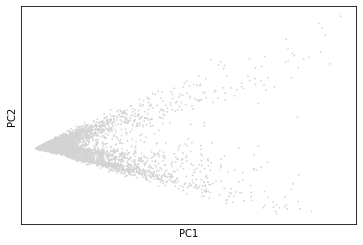

In [192]:
sc.tl.pca(filtered, svd_solver='arpack')
sc.pl.pca(filtered)

In [193]:
sc.pp.neighbors(filtered, n_neighbors=15)

/home/estorrs/miniconda3/envs/pollock/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/pollock/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


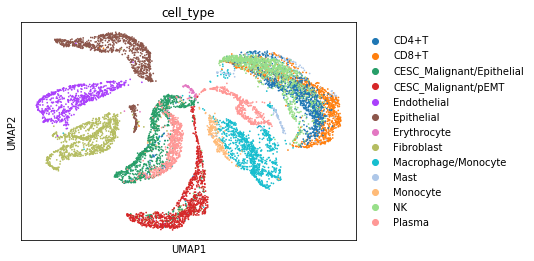

In [194]:
sc.tl.umap(filtered)
sc.pl.umap(filtered, color=cell_type_key, edges=False)

In [ ]:
# sc.pp.neighbors(adata, n_neighbors=15)

In [ ]:
# g_template, c_template = pollock.models.model.create_block_image_template(
#         adata, key='x', block_shape=(4, 4), size=(128, 128), nn_threshold=.05)
# g_template, c_template

In [ ]:
# sorted(set(c_template.flatten()))

In [ ]:
# plt.imshow(c_template=='')

## train pollock model

In [12]:
# cell_labels = pollock_dataset.adata[pollock_dataset.train_cell_ids].obs[cell_type_key]
# counts = Counter(cell_labels)
# cell_type_to_weight = {c: (1 / count) * len(cell_labels) / len(counts)
#         for c, count in counts.items()}
# cell_type_to_weight

In [15]:
np.repeat([[1,2,3]], 5, axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [70]:
%%time
# pollock_dataset = pollock.models.model.PollockDataset(filtered, cell_type_key=cell_type_key, dataset_type='training',
#                                 image_root_dir=training_image_dir, batch_size=batch_size,
#                                 n_per_cell_type=5000, max_val_per_cell_type=10000,
#                                 block_shape=(8,8), template_shape=(128, 128),
#                                 template_generation_max_per_cell=100)
pollock_dataset = pollock.models.model.PollockDataset(adata, cell_type_key=cell_type_key, dataset_type='training',
                                image_root_dir=training_image_dir, batch_size=batch_size,
                                n_per_cell_type=1000, max_val_per_cell_type=10000,
                                block_shape=(8,8), template_shape=(128, 128),
                                template_generation_max_per_cell=100)

2020-02-20 23:40:22,340 creating image templates
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'x' as categorical
2020-02-20 23:40:26,073 setting up close groupings
2020-02-20 23:40:26,073 calculating nearest neighbors
2020-02-20 23:40:26,758 calculating connectivities
2020-02-20 23:40:28,163 calculating differential genes
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns

CPU times: user 4min 32s, sys: 1min 6s, total: 5min 38s
Wall time: 4min 3s


In [63]:
x,y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 11]))

(1, 20387) (20387,)


/tf/pollock/pollock/models/model.py:524: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])


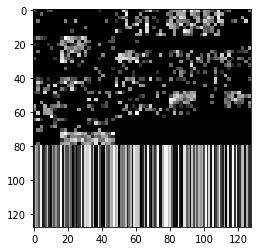

In [64]:
cell_id = adata.obs.index[0]

img = pollock_dataset.get_cell_images([cell_id])

In [56]:
# from IPython.display import Image
# Image(filename='/models/scratch/zheng_68k_unsorted/training/0640838a-0984-4794-8175-4eb1494baa44/AAATCTGACTTATC-7_13.jpg') 

In [65]:
pollock_dataset.cell_types, sorted(set(pollock_dataset.cell_type_template.flatten()))

(['CD14+ Monocyte',
  'CD19+ B',
  'CD34+',
  'CD4+ T Helper2',
  'CD4+/CD25 T Reg',
  'CD4+/CD45RA+/CD25- Naive T',
  'CD4+/CD45RO+ Memory',
  'CD56+ NK',
  'CD8+ Cytotoxic T',
  'CD8+/CD45RA+ Naive Cytotoxic',
  'Dendritic'],
 ['',
  'CD14+ Monocyte',
  'CD14+ Monocyte_diff_Dendritic',
  'CD19+ B',
  'CD19+ B_diff_CD4+ T Helper2',
  'CD19+ B_diff_CD4+/CD25 T Reg',
  'CD19+ B_diff_CD4+/CD45RA+/CD25- Naive T',
  'CD19+ B_diff_CD8+ Cytotoxic T',
  'CD19+ B_diff_CD8+/CD45RA+ Naive Cytotoxic',
  'CD34+',
  'CD34+_diff_CD4+ T Helper2',
  'CD4+ T Helper2',
  'CD4+ T Helper2_diff_CD4+/CD25 T Reg',
  'CD4+ T Helper2_diff_CD4+/CD45RA+/CD25- Naive T',
  'CD4+ T Helper2_diff_CD4+/CD45RO+ Memory',
  'CD4+ T Helper2_diff_CD8+ Cytotoxic T',
  'CD4+ T Helper2_diff_CD8+/CD45RA+ Naive Cytotoxic',
  'CD4+ T Helper2_diff_Dendritic',
  'CD4+/CD25 T Reg',
  'CD4+/CD25 T Reg_diff_CD4+/CD45RA+/CD25- Naive T',
  'CD4+/CD25 T Reg_diff_CD4+/CD45RO+ Memory',
  'CD4+/CD25 T Reg_diff_CD8+ Cytotoxic T',
  'CD4+/CD

In [66]:
# plt.imshow(pollock_dataset.cell_type_template=='CESC_Malignant/Epithelial_diff_CESC_Malignant/pEMT')

In [71]:
model = PollockModel(pollock_dataset.cell_types, img_height=pollock_dataset.template_shape[0],
                     img_width=pollock_dataset.template_shape[1], learning_rate=.0005,
                     model=None)
# model = PollockModel(pollock_dataset.cell_types, model='resnet50')

In [72]:
model.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

In [ ]:
# with tf.device('/device:XLA_GPU:0'):

model.fit(pollock_dataset, epochs=10, batch_size=batch_size, balance_classes=True)

Train for 825 steps, validate for 207 steps
Epoch 1/10
825/825 [==============================] - 20s 25ms/step - loss: 1.0160 - accuracy: 0.6218 - val_loss: 0.8841 - val_accuracy: 0.6670
Epoch 2/10
825/825 [==============================] - 13s 15ms/step - loss: 0.9077 - accuracy: 0.6560 - val_loss: 0.8657 - val_accuracy: 0.6655
Epoch 3/10
157/825 [====>.........................] - ETA: 9s - loss: 0.8904 - accuracy: 0.6647

In [20]:
%%time
cell_ids = sorted(set(pollock_dataset.train_cell_ids))

X_train = pollock_dataset.get_cell_images(cell_ids, show=False)

mask = np.asarray([True if c in set(cell_ids) else False
                   for c in pollock_dataset.adata.obs.index])
y_train = np.asarray(pollock_dataset.adata.obs[mask].loc[cell_ids][cell_type_key])

X_train.shape, y_train.shape

/home/estorrs/pollock/pollock/models/model.py:455: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])


CPU times: user 18.5 s, sys: 325 ms, total: 18.8 s
Wall time: 18.8 s


((6850, 128, 128, 3), (6850,))

In [21]:
%%time
cell_ids = sorted(set(pollock_dataset.val_cell_ids))

X_val = pollock_dataset.get_cell_images(cell_ids, show=False)

mask = np.asarray([True if c in set(cell_ids) else False
                   for c in pollock_dataset.adata.obs.index])
y_val = np.asarray(pollock_dataset.adata.obs[mask].loc[cell_ids][cell_type_key])
X_val.shape, y_val.shape

CPU times: user 4.21 s, sys: 77.9 ms, total: 4.29 s
Wall time: 4.28 s


((1719, 128, 128, 3), (1719,))

In [22]:
metadata = {
    'dataset': {
        'name': run_name,
        'total_cells': adata.shape[0],
        'cell_types': pollock_dataset.cell_types,
        'cell_counts': counts.most_common(),
    },
    'model_training': {
        'training_pool_size_per_cell_type': n_per_cell_type,
        'validation_size': pollock_dataset.val_length,
        'training_size': pollock_dataset.train_length,
        'epochs': epochs,
        'train_cell_ids': pollock_dataset.train_cell_ids,
        'val_cell_ids': pollock_dataset.val_cell_ids,
        'batch_size': batch_size
    }
}

In [23]:
model.save(pollock_dataset, model_save_dir,
          X_val=X_val, y_val=y_val, X_train=X_train, y_train=y_train, metadata=metadata)

In [353]:
import json
d = json.load(open(model_save_dir + '/summary.json'))

In [354]:
d.keys()

dict_keys(['dataset', 'model_training', 'history', 'validation', 'training'])

In [134]:
prediction_dataset, model = load_from_directory(adata, model_save_dir,
        image_root_dir=os.path.join('/home/estorrs/pollock/models', 'scratch', 'test_prediction'))

2020-02-17 11:33:11,733 writing images
2020-02-17 11:33:14,085 0 cell images written
/home/estorrs/pollock/pollock/models/model.py:242: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])
2020-02-17 11:33:16,515 1000 cell images written
2020-02-17 11:33:18,989 2000 cell images written
2020-02-17 11:33:21,412 3000 cell images written
2020-02-17 11:33:23,838 4000 cell images written
2020-02-17 11:33:26,263 5000 cell images written
2020-02-17 11:33:28,698 6000 cell images written
2020-02-17 11:33:31,129 7000 cell images written
2020-02-17 11:33:33,554 8000 cell images written
2020-02-17 11:33:35,977 9000 cell images written
2020-02-17 11:33:38,397 10000 cell images written
2020-02-17 11:33:40,819 11000 cell images written
2020-02-17 11:33:43,240 12000 cell images written
2020-02-17 11:33:45,264 done writing images


Found 12829 images belonging to 1 classes.


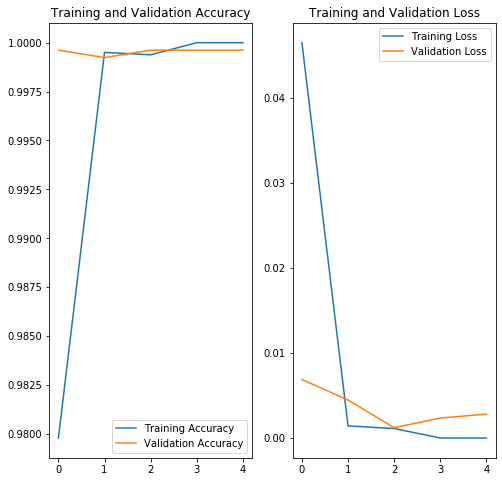

In [27]:
pollock_analysis.show_history(model.history)

In [178]:
%%time
# prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/abm_3class',
#         image_root_dir = '/home/estorrs/pollock/models/scratch/test_amb_prediction')

# prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/zheng_68k_unfiltered',
#         image_root_dir = '/home/estorrs/pollock/models/scratch/test_zheng_68k_unfiltered_prediction')

CPU times: user 28 µs, sys: 7 µs, total: 35 µs
Wall time: 69.6 µs


In [340]:
# # probs = model.predict(prediction_dataset)
# probs = model.predict(prediction_dataset.prediction_ds)

# probs.shape

In [60]:
# probs = model.predict(prediction_dataset)
probs = model.predict(X_val)

probs.shape

(3941, 8)

In [61]:
predictions = np.argmax(probs, axis=1).flatten()
max_prob = np.asarray([np.max(x) for x in probs])
predicted_labels = [pollock_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

(3941, array([7, 4, 1, 4, 6]))

In [35]:
plt.hist(ls, )

NameError: name 'ls' is not defined

In [62]:
# cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
# groundtruth = [cell_type_to_index[cell_type]
#                for cell_type in adata[prediction_dataset.cell_ids, :].obs['x']]

cell_type_to_index = {v:k for k, v in enumerate(pollock_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in y_val]
len(groundtruth), groundtruth[:5]

(3941, [7, 4, 1, 4, 6])

In [469]:
predictions, groundtruth = zip(*[(p, g) for p, g, prob in zip(predictions, groundtruth, max_prob)
                                if prob > .99])
len(predictions), len(groundtruth)

(13004, 13004)

In [63]:
from sklearn.metrics import classification_report
report = classification_report(groundtruth, predictions, target_names=pollock_dataset.cell_types,
                               output_dict=True)
report

{'B cell': {'precision': 0.9163265306122449,
  'recall': 0.9760869565217392,
  'f1-score': 0.9452631578947368,
  'support': 460},
 'CD14+ monocyte': {'precision': 0.9345549738219895,
  'recall': 0.9394736842105263,
  'f1-score': 0.937007874015748,
  'support': 760},
 'CD16+ monocyte': {'precision': 0.8,
  'recall': 0.8571428571428571,
  'f1-score': 0.8275862068965518,
  'support': 112},
 'CD4+ T cell': {'precision': 0.8935361216730038,
  'recall': 0.8047945205479452,
  'f1-score': 0.8468468468468469,
  'support': 876},
 'Cytotoxic T cell': {'precision': 0.8606965174129353,
  'recall': 0.899702823179792,
  'f1-score': 0.8797675263349074,
  'support': 1346},
 'Dendritic cell': {'precision': 0.8604651162790697,
  'recall': 0.8809523809523809,
  'f1-score': 0.8705882352941177,
  'support': 42},
 'Megakaryocyte': {'precision': 0.9777777777777777,
  'recall': 0.9723756906077348,
  'f1-score': 0.9750692520775623,
  'support': 181},
 'Natural killer cell': {'precision': 0.7837837837837838,
  '

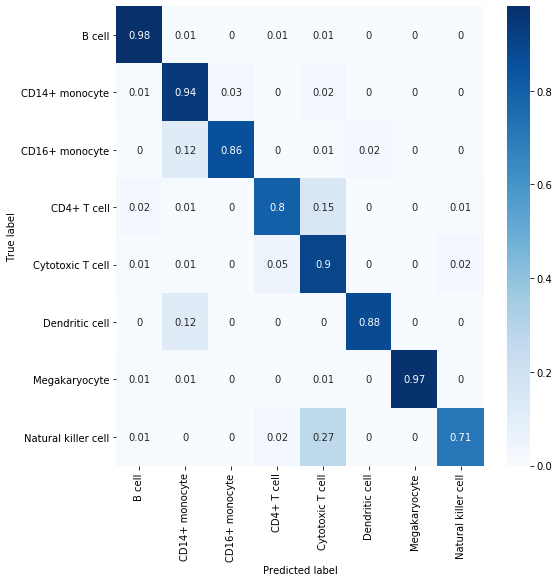

In [64]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, pollock_dataset.cell_types)

In [208]:
(y_val=='CESC_Malignant/Epithelial') & (np.asarray(predicted_labels)=='CESC_Malignant/pEMT')




1084

In [214]:
import tensorflow as tf
list_ds = tf.data.Dataset.list_files(str(training_image_dir + '/validation' + '/*/*'))

In [228]:
[fp.numpy().decode('utf-8').split(os.path.sep)[-1].replace('.jpg', '') for fp in list(list_ds)]

['ACCAAACCAACAACAA-1_9',
 'GCCAGGTTCTCATGGA-1_9',
 'TCTCACGAGACGATAT-1_8',
 'TAGGTTGAGAGGGTGG-1_8',
 'TGCATCCAGGTACAGC-1_9',
 'TAGACCAGTCTACAGT-1_9',
 'TGAATCGTCTACGCAA-1_8',
 'GTTATGGAGTTGTAAG-1_9',
 'TGTAGACTCTTCGATT-1_8',
 'TGCAGTAGTCTGGTTA-1_9',
 'TTCTTCCTCGGCCTTT-1_9',
 'TCGAAGTGTACAATAG-1_7',
 'GATCAGTAGGCATCTT-1_9',
 'TCCCATGAGATGCTAA-1_9',
 'AGGGTTTAGTTTCAGC-1_9',
 'TGCTTCGGTCGTACTA-1_9',
 'TCATACTTCACCGACG-1_7',
 'TGTCCCACATCAGTGT-1_8',
 'TGAGGTTCAGTTACCA-1_7',
 'TATCTGTTCCTACACC-1_9',
 'GCATCTCCACAAGCTT-1_9',
 'TTCAGGATCCGATTAG-1_9',
 'GTAGTACAGGTAAACT-1_9',
 'TTCATTGCAGGTGGAT-1_7',
 'CATAAGCAGCTGTCCG-1_4',
 'TGAGCGCTCACGGAGA-1_9',
 'TGCGGCAAGTAATCCC-1_9',
 'TTGACCCCAGAGATTA-1_9',
 'GAGAGGTTCGCTAAAC-1_9',
 'GGTGAAGGTTCCCACT-1_9',
 'TGTAGACTCCTAAGTG-1_8',
 'GGGACCTTCCATTCAT-1_7',
 'TAGGTTGCACGAAGAC-1_9',
 'TGTTGAGGTCAACCTA-1_8',
 'GTCAAACGTGATTAGA-1_9',
 'TGTTGAGTCGTGACTA-1_7',
 'TTGCATTGTGTCATCA-1_7',
 'TTTACCAGTGGCTGCT-1_9',
 'TGATCTTGTTGGCTAT-1_8',
 'TTTGTTGGTAATGCGG-1_7',


In [202]:
predicted_labels

['CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'Fibroblast',
 'Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'Macrophage/Monocyte',
 'CD4+T',
 'Plasma',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'Fibroblast',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/Epithelial',
 'NK',
 'CESC_Malignant/pEMT',
 'CD4+T',
 'NK',
 'Epithelial',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'NK',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'NK',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CD4+T',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pE

In [65]:
embedding = pollock_analysis.umap_final_layer(X_val, model)
embedding.shape

(3941, 2)

... storing 'predicted_cell_type' as categorical
... storing 'groundtruth_cell_type' as categorical


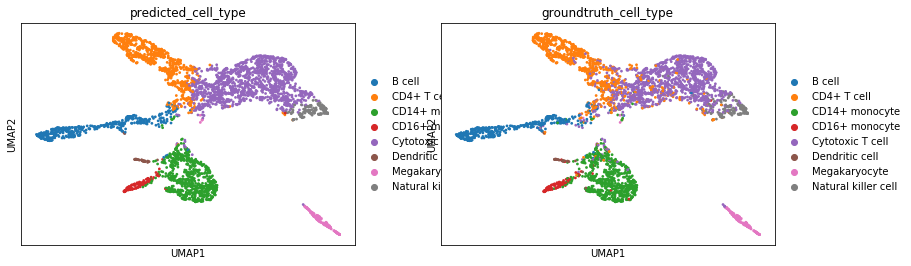

In [66]:
ordered_adata = anndata.AnnData(X=np.full((len(y_val), len(y_val)), 1.))
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
ordered_adata.obs['groundtruth_cell_type'] = y_val
sc.pl.umap(ordered_adata, color=['predicted_cell_type', 'groundtruth_cell_type'])

In [136]:
ordered_adata = adata[y_val, :]
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(ordered_adata, color=['predicted_cell_type', cell_type_key])

KeyError: "Values ['HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Plasma', 'Endothelial', 'B', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Mast', 'Plasma', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Fibroblast', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'B', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'B', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'CD4+T', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Mast', 'CD4+T', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'B', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Plasma', 'B', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Mast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD8+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Endothelial', 'Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'B', 'Fibroblast', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Mast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'NK', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Macrophage/Monocyte', 'Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'B', 'CD4+T', 'Mast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'Mast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Mast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'Plasma', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Plasma', 'Monocyte', 'CD4+T', 'NK', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'B', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'CD4+T', 'Mast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Mast', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'NK', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Mast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'CD4+T', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial'], from ['HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Plasma', 'Endothelial', 'B', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Mast', 'Plasma', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Fibroblast', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'B', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'B', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'CD4+T', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Mast', 'CD4+T', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'B', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Plasma', 'B', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Mast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD8+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Endothelial', 'Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'B', 'Fibroblast', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Mast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'NK', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Macrophage/Monocyte', 'Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'B', 'CD4+T', 'Mast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'Mast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Mast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'Plasma', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Plasma', 'Monocyte', 'CD4+T', 'NK', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'B', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'CD4+T', 'Mast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Mast', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'NK', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Mast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'CD4+T', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial'], are not valid obs/ var names or indices."